# 【問題1】自作データセットでの分類の学習

# os.listdir  vs  glob.glob

https://stackoverflow.com/questions/13643558/should-glob-glob-be-preferred-over-os-listdir-or-the-other-way-around

In [1]:
import numpy  as np
import os
import glob 
import re
import random
from PIL import Image
from sklearn.model_selection import train_test_split

## osを使用する場合

In [2]:
path = './dog_cat/' 

## globを使用する場合

In [4]:
img_list = glob.glob(path + '/*' + ".jpeg")

# イメージのロード、配列化、リサイズ、データセット

In [5]:
# dog_img_array = np.empty((0,224,224,3))
# cat_img_array = np.empty((0,224,224,3))
random.shuffle(img_list)
x=[]
y=[]
for img in img_list:
    
    # ファイル名に'dog'が含まれるイメージ
    if re.search('dog_cat/dog', img):
        dog_img = Image.open(img)
        dog_img = dog_img.convert("RGB")
        dog_img = dog_img.resize((75,75))
        dog_img = np.asarray(dog_img)
        dog_img = dog_img/256
        dog_img = dog_img.reshape(75,75,3)

        x.append(dog_img)
        y.append(0)
    # ファイル名に'cat'が含まれるイメージ
    if re.search('dog_cat/cat', img):
        cat_img = Image.open(img)
        cat_img = cat_img.convert("RGB")
        cat_img = cat_img.resize((75,75))
        cat_img = np.asarray(cat_img)
        cat_img = cat_img/256
        cat_img = cat_img.reshape(75,75,3)

        x.append(cat_img)
        y.append(1)

In [6]:
img[10:13]

'dog'

In [7]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers

In [8]:
classes = 1
data_size = 75 * 75 * 3

In [9]:
def train(x,y):
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(75, 75, 3)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))        # 犬猫と同じ2クラス分類で

    # モデルのコンパイル
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
    
    model.fit(x,y,epochs=30)
    return model
    

In [10]:
def model_eval(model,X_test,y_test):
    score = model.evaluate(X_test,y_test)
    print('loss=',score[0])
    print('accuracy=',score[1])

In [11]:
x = np.array(x,dtype=np.float32)
# x = np.reshape(x,(-data_sizesize))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
model = train(X_train,y_train)
model_eval(model,X_test,y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
24/24 [==============================] - 1s 40ms/sample - loss: 0.6971 - acc: 0.4583
Epoch 2/30
24/24 [==============================] - 0s 17ms/sample - loss: 0.7465 - acc: 0.6250
Epoch 3/30
24/24 [==============================] - 0s 19ms/sample - loss: 0.6764 - acc: 0.5417
Epoch 4/30
24/24 [==============================] - 0s 16ms/sample - loss: 0.6411 - acc: 0.6250
Epoch 5/30
24/24 [==============================] - 0s 12ms/sample - loss: 0.6128 - acc: 0.6250
Epoch 6/30
24/24 [==============================] - 0s 13ms/sample - loss: 0.5932 - acc: 0.6250
Epoch 7/30
24/24 [==============================] - 0s 15ms/sample - loss: 0.5742 - acc: 0.7917
Epoch 8/30
24/24 [==============================] - 0s 15ms/sample - loss: 0.5541 - acc: 0.6250
Epoch 9/30
24/24 [==============================] - 0s 14ms/sample - loss: 0.5566 - acc: 0.8750
Epoch 10/30
24/2

In [12]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


# 【問題2】分類データセットに対するデータ拡張

データ拡張（Data Augmentation）を行ってください。

データ拡張のためのライブラリ

データ拡張にはalbumentationsなどがあります。

[albu/albumentations: fast image augmentation library and easy to use wrapper around other libraries](https://github.com/albu/albumentations)

また、Kerasを使う場合はImageDataGeneratorも便利です。


データ拡張の効果の調査

データ拡張には様々な方法があります。今回のタスクにおいて各手法がどう効果があるかを実験・考察してください。

In [13]:
%matplotlib inline
from urllib.request import urlopen
import os
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [14]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [15]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [16]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

In [17]:
image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')

In [18]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [18, 17]}
category_id_to_name = {17: 'cat', 18: 'dog'}

## Original image

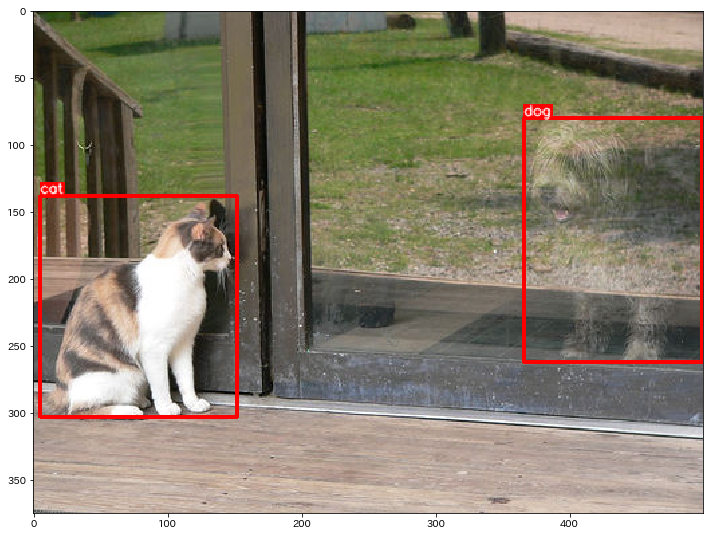

In [19]:
visualize(annotations, category_id_to_name)

## Few simple cases

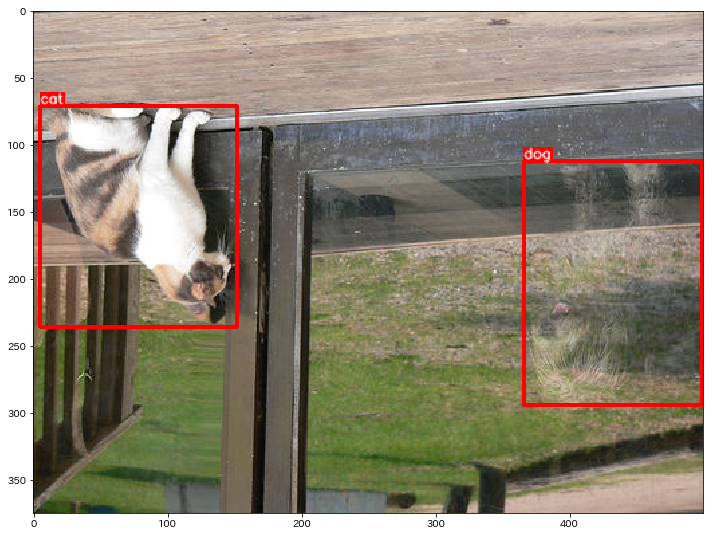

In [20]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

## また、Kerasを使う場合はImageDataGeneratorも便利です

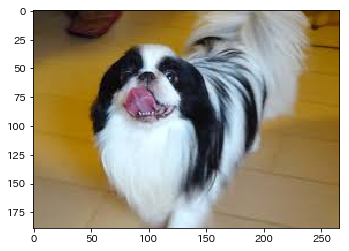

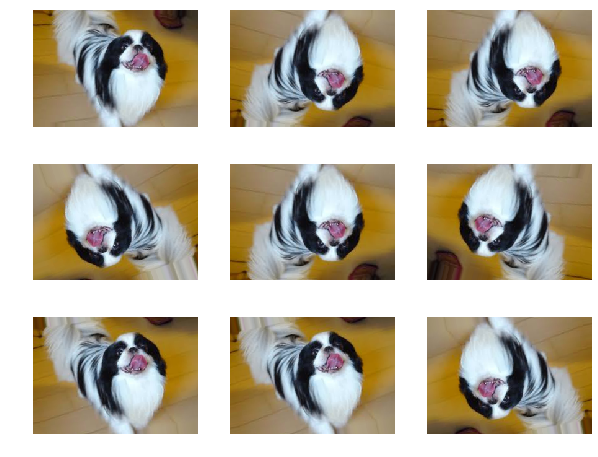

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# 画像を読み込む。
img = image.load_img('./dog_cat/dog0020.jpeg')
img = np.array(img)

plt.imshow(img)
plt.show()

# 画像データ生成器を作成する。
# -20° ~ 20° の範囲でランダムに回転を行う。
# ランダムに左右上下反転する。
datagen = image.ImageDataGenerator(rotation_range=20,horizontal_flip=True,vertical_flip=True)

# ミニバッチを生成する Python ジェネレーターを作成する。
x = img[np.newaxis]  #  (Height, Width, Channels)  -> (1, Height, Width, Channels) 
gen = datagen.flow(x, batch_size=1)  # 1枚しかないので、ミニバッチ数は1

# Python ジェネレーターで9枚生成して、表示する。
plt.figure(figsize=(10, 8))
for i in range(9):
    batches = next(gen)  # (NumBatches, Height, Width, Channels) の4次元データを返す。
    # 画像として表示するため、3次元データにし、float から uint8 にキャストする。
    gen_img = batches[0].astype(np.uint8)

    plt.subplot(3, 3, i + 1)
    plt.imshow(gen_img)
    plt.axis('off')
plt.show()


# 画像データ生成器を作成する。
# ランダムに左右反転する。


In [22]:
#Data Augmentationを一度に作る関数
def augmentation(img1):
    if re.search('dog_cat/dog', img1):
        img1 = image.load_img(img1)
        save_path = 'output'  # 保存ディレクトリのパス

        # 指定したディレクトリが存在しないとエラーになるので、
        # 予め作成しておく。
        import os
        os.makedirs(save_path, exist_ok=True)
        img = np.array(img1)

        # -20° ~ 20° の範囲でランダムに回転する。。 
        datagen = image.ImageDataGenerator(rotation_range=20,height_shift_range=0.3,width_shift_range=0.3)

        # ミニバッチを生成するジェネレーターを作成する。
        x = img[np.newaxis]  #  (Height, Width, Channels)  -> (1, Height, Width, Channels) 
        gen = datagen.flow(x, batch_size=1, save_to_dir=save_path,
                           save_prefix='dog', save_format='jpeg')

        # ジェネレーターで9枚生成する。
        plt.figure(figsize=(10, 8))
        for i in range(3):
            # ミニバッチを生成したタイミングでディレクトリに
            # 画像が保存される。
            next(gen)
    else:
        img1 = image.load_img(img1)
        save_path = 'output'  # 保存ディレクトリのパス

        # 指定したディレクトリが存在しないとエラーになるので、
        # 予め作成しておく。
        import os
        os.makedirs(save_path, exist_ok=True)
        img = np.array(img1)
        datagen = image.ImageDataGenerator(rotation_range=20)

        # ミニバッチを生成するジェネレーターを作成する。
        x = img[np.newaxis]  #  (Height, Width, Channels)  -> (1, Height, Width, Channels) 
        gen = datagen.flow(x, batch_size=1, save_to_dir=save_path,
                           save_prefix='cat', save_format='jpeg')

        # ジェネレーターで9枚生成する。
        plt.figure(figsize=(10, 8))
        for i in range(3):
            # ミニバッチを生成したタイミングでディレクトリに
            # 画像が保存される。
            next(gen)
        

In [23]:
for img in img_list:
    augmentation(img)

/anaconda3/envs/DIC/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

# 【問題3】物体検出データセットの用意

次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

アノテーションのためのツール

アノテーションツールにはLabelImgなどがあります

XMLファイルの一例を掲載

In [ ]:
<annotation>
	<folder>dog_cat</folder>
	<filename>dog0020.jpeg</filename>
	<path>/Users/y-shiraishi/DIVEINTOCODE/diveintocode-term2/sprint19/dog_cat/dog0020.jpeg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>266</width>
		<height>189</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>dog</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>51</xmin>
			<ymin>3</ymin>
			<xmax>236</xmax>
			<ymax>170</ymax>
		</bndbox>
	</object>
</annotation>